In [2]:
# En cas de problème pour importer tensoflow depuis un jupyter notebook:
# https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## Exploration du dataset

In [4]:
df = pd.read_csv("./winequality.csv")

In [5]:
df

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,white,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,white,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,red,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
6493,red,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,NaN,11.2,6
6494,red,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
6495,red,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [6]:
df["type"].value_counts()

,count
type,
white,4898
red,1599


In [7]:
df["quality"].value_counts()

,count
quality,
6,2836
5,2138
7,1079
4,216
8,193
3,30
9,5


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [9]:
target = "quality"
X = df.drop(target, axis=1)
y = df[target]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

In [11]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(3897, 12)
(1300, 12)
(1300, 12)
(3897,)
(1300,)
(1300,)


In [12]:
X_train.to_csv("./X_train.csv")
X_val.to_csv("./X_val.csv")
X_test.to_csv("./X_test.csv")
y_train.to_csv("./y_train.csv")
y_val.to_csv("./y_val.csv")
y_test.to_csv("./y_test.csv")

In [13]:
# On normalise les valeurs cibles pour aider le modèle.
# Il faudra choisir pour la couche de sortie la fonction d'activation sigmoïde
y_train = y_train/10
y_val = y_val/10
y_test = y_test/10

## Traitement des variables

In [14]:
numeric_cols = list(X_train.columns[1:])
numeric_pipeline = Pipeline(steps = [
    ("imputation", SimpleImputer(strategy="mean")),
    ("normalisation", MinMaxScaler()),
])

In [15]:
categorical_cols = ["type"]
categorical_pipeline = Pipeline(steps = [
    ("encodage", OneHotEncoder(drop = "first"))
])

In [16]:
preprocessor = ColumnTransformer(transformers = [
    ("numeric", numeric_pipeline, numeric_cols),
    ("categorical", categorical_pipeline, categorical_cols),
], )

In [17]:
X_train_clean = preprocessor.fit_transform(X_train)
X_val_clean = preprocessor.transform(X_val)
X_test_clean = preprocessor.transform(X_test)

In [18]:
pd.DataFrame(X_train_clean, columns=numeric_cols + ["white"]).to_csv("./X_train_clean.csv")
pd.DataFrame(X_val_clean, columns=numeric_cols + ["white"]).to_csv("./X_val_clean.csv")
pd.DataFrame(X_test_clean, columns=numeric_cols + ["white"]).to_csv("./X_test_clean.csv")

In [19]:
def plot_history(history):
    fig, axes = plt.subplots(1,2, figsize=(15,6))
    hist_data = history.history
    hist_data["epochs"] = list(range(1, len(history.history["loss"])+1))

    hist_data = pd.DataFrame(hist_data)
    sns.lineplot(data=hist_data, x="epochs", y="loss", ax=axes[0], color = "blue")
    sns.lineplot(data=hist_data, x="epochs", y="val_loss", ax=axes[0], color = "orange")

    sns.lineplot(data=hist_data, x="epochs", y="mae", ax=axes[1], color = "blue")
    sns.lineplot(data=hist_data, x="epochs", y="val_mae", ax=axes[1], color = "orange")

## Création du modèle

In [20]:
input_dim = X_train.shape[1]
input_dim

12

### Sans fonction

In [21]:
model = Sequential()

In [22]:
model.add(Dense(5, input_dim=input_dim, activation="relu"))
model.add(Dense(10, activation="relu"))
model.add(Dense(10, activation="relu"))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
model.add(Dense(1, activation="sigmoid",name="output_layer"))

In [24]:
model.compile(optimizer = 'rmsprop', loss = "mse", metrics = ["mae", "mse"])

In [25]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 5)                   │              65 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 246 (984.00 B)

 Trainable params: 246 (984.00 B)

 Non-trainable params: 0 (0.00 B)

In [26]:
nb_epochs = 500

#### Entraînement

In [27]:
history = model.fit(X_train_clean, y_train, epochs=nb_epochs, validation_data=(X_val_clean, y_val))

Epoch 1/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0092 - mae: 0.0761 - mse: 0.0092 - val_loss: 0.0069 - val_mae: 0.0631 - val_mse: 0.0069
Epoch 2/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0062 - mae: 0.0606 - mse: 0.0062 - val_loss: 0.0063 - val_mae: 0.0607 - val_mse: 0.0063
Epoch 3/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0057 - mae: 0.0583 - mse: 0.0057 - val_loss: 0.0061 - val_mae: 0.0603 - val_mse: 0.0061
Epoch 4/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0053 - mae: 0.0560 - mse: 0.0053 - val_loss: 0.0061 - val_mae: 0.0596 - val_mse: 0.0061
Epoch 5/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0053 - mae: 0.0561 - mse: 0.0053 - val_loss: 0.0060 - val_mae: 0.0592 - val_mse: 0.0060
Epoch 6/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0053 - mae: 0.0565 - mse: 0.0053 - val_loss: 0.0060 - val_mae: 0.0595 - val_mse: 0.0060
Epoch 7/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0055 - mae: 0.0576 - mse: 0.005

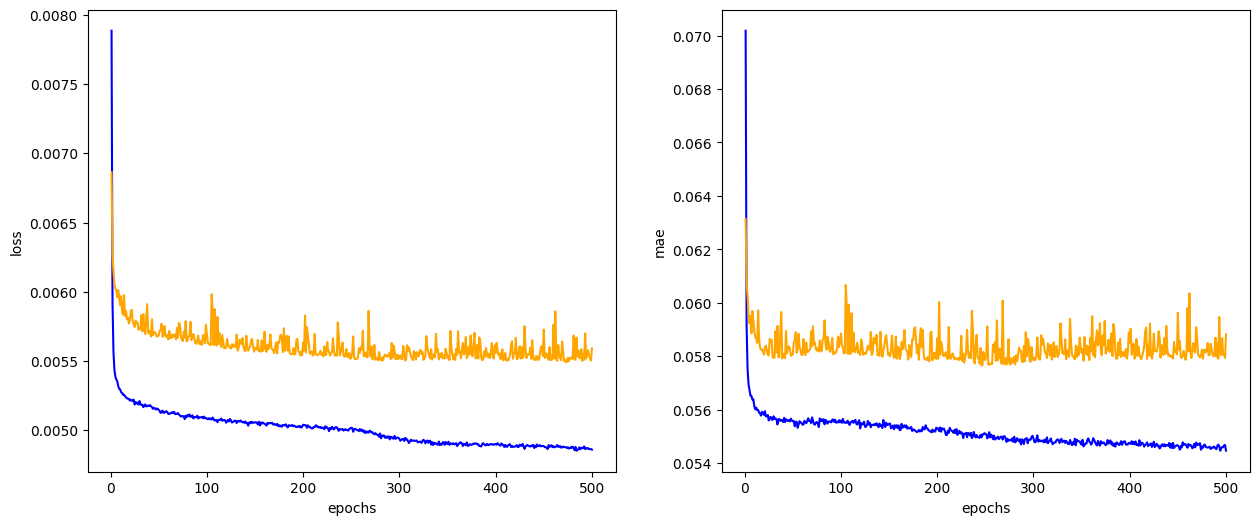

In [28]:
plot_history(history)

### Avec fonction

In [29]:
def create_model(input_dim, nb_hidden_layers=3, nb_units=20, activation="relu", optimizer="rmsprop", loss="mse", metrics=["mae", "mse"]):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    #model.add(Dense(nb_units, input_dim=input_dim, activation=activation))
    for i in range(nb_hidden_layers-1):
       model.add(Dense(nb_units, activation=activation))

    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
    model.summary()
    return model

In [30]:
model = create_model(
    input_dim=input_dim,
    nb_hidden_layers=4,
    nb_units=12,
    activation="relu",
    optimizer="rmsprop",
    loss="mse",
    metrics=["mae", "mse"]
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 12)                  │             156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 12)                  │             156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 12)                  │             156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              13 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 481 (1.88 KB)

 Trainable params: 481 (1.88 KB)

 Non-trainable params: 0 (0.00 B)

#### Entraînement

In [31]:
nb_epochs = 5
history = model.fit(
    X_train_clean,
    y_train,
    epochs=nb_epochs,
    validation_data=(X_val_clean, y_val),
    callbacks = [
        #EarlyStopping(patience=3), # Arrête l'entraînement si le loss de diminue pas après 3 époques consécutives
        #ModelCheckpoint("./models") # Sauvegarde les modèles obtenus à la fin de chaque époque
    ]
)

Epoch 1/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0152 - mae: 0.0973 - mse: 0.0152 - val_loss: 0.0069 - val_mae: 0.0656 - val_mse: 0.0069
Epoch 2/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0062 - mae: 0.0624 - mse: 0.0062 - val_loss: 0.0065 - val_mae: 0.0641 - val_mse: 0.0065
Epoch 3/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0059 - mae: 0.0605 - mse: 0.0059 - val_loss: 0.0063 - val_mae: 0.0630 - val_mse: 0.0063
Epoch 4/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0060 - mae: 0.0608 - mse: 0.0060 - val_loss: 0.0062 - val_mae: 0.0619 - val_mse: 0.0062
Epoch 5/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0053 - mae: 0.0581 - mse: 0.0053 - val_loss: 0.0060 - val_mae: 0.0610 - val_mse: 0.0060


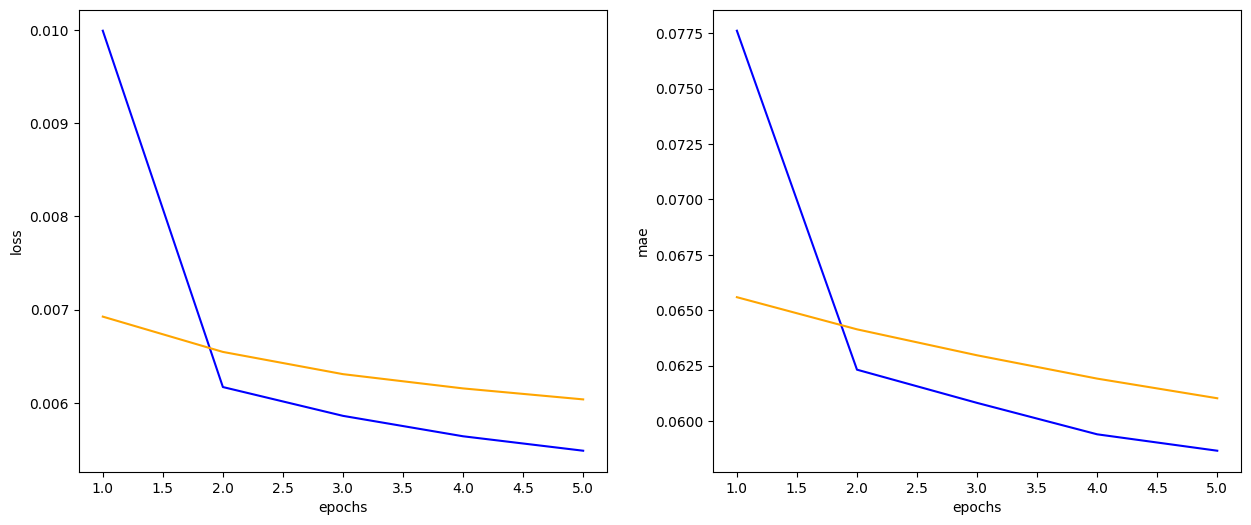

In [32]:
plot_history(history)

## Evaluation du modèle

In [33]:
y_pred = model.predict(X_test_clean)

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [34]:
mean_squared_error(y_pred, y_test)

0.0055499608418912725

In [35]:
# Le modèle a été entraîné à prédire des notes entre 0 et 10.
# On remultiplie les vecteur y_pred et y_test pour avoir une métrique interprétable
mean_absolute_error(y_pred*10, y_test*10)

0.58589422922868

## Compatibilité avec un GridSearchCV

In [38]:
!pip install scikeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 61.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2


In [39]:
from scikeras.wrappers import KerasRegressor

In [40]:
model_keras = KerasRegressor(model=create_model, epochs = 10)

In [41]:
hyperparameters = {
    "model__input_dim": [input_dim],
    "model__activation": ["relu", "sigmoid"],
    "model__nb_hidden_layers": [2,3],
    "model__nb_units": [10, 20],
    "model__optimizer": ["rmsprop", "adam"],
    "model__loss": ["mse"]
}

In [42]:
grid = GridSearchCV(estimator=model_keras, param_grid=hyperparameters, cv=2)

In [43]:
grid.fit(X_train_clean, y_train)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                      │ (None, 10)                  │             130 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 141 (564.00 B)

 Trainable params: 141 (564.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0145 - mae: 0.0970 - mse: 0.0145
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0081 - mae: 0.0709 - mse: 0.0081
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0070 - mae: 0.0636 - mse: 0.0070
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0065 - mae: 0.0621 - mse: 0.0065
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - mae: 0.0582 - mse: 0.0056
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0059 - mae: 0.0595 - mse: 0.0059
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 - mae: 0.0606 - mse: 0.0059
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0059 - mae: 0.0595 - mse: 0.0059
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0058 - mae: 0.0597 - mse: 0.0058
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0054 - mae: 0.0573 - mse: 0.0054
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                      │ (None, 10)                  │             130 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 141 (564.00 B)

 Trainable params: 141 (564.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0122 - mae: 0.0869 - mse: 0.0122
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0070 - mae: 0.0636 - mse: 0.0070
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070 - mae: 0.0638 - mse: 0.0070
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068 - mae: 0.0640 - mse: 0.0068
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0064 - mae: 0.0620 - mse: 0.0064
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0064 - mae: 0.0627 - mse: 0.0064
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0059 - mae: 0.0614 - mse: 0.0059
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0059 - mae: 0.0602 - mse: 0.0059
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0056 - mae: 0.0588 - mse: 0.0056
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0060 - mae: 0.0602 - mse: 0.0060
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                     │ (None, 10)                  │             130 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 141 (564.00 B)

 Trainable params: 141 (564.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0086 - mae: 0.0723 - mse: 0.0086
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0070 - mae: 0.0656 - mse: 0.0070
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0062 - mae: 0.0611 - mse: 0.0062
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0062 - mae: 0.0616 - mse: 0.0062
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0054 - mae: 0.0575 - mse: 0.0054
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0058 - mae: 0.0605 - mse: 0.0058
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0058 - mae: 0.0609 - mse: 0.0058
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0058 - mae: 0.0606 - mse: 0.0058
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0056 - mae: 0.0594 - mse: 0.0056
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0054 - mae: 0.0586 - mse: 0.0054
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_13 (Dense)                     │ (None, 10)                  │             130 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 141 (564.00 B)

 Trainable params: 141 (564.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0503 - mae: 0.2016 - mse: 0.0503
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0086 - mae: 0.0737 - mse: 0.0086
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071 - mae: 0.0660 - mse: 0.0071
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0066 - mae: 0.0636 - mse: 0.0066
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0067 - mae: 0.0640 - mse: 0.0067
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0064 - mae: 0.0622 - mse: 0.0064
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0061 - mae: 0.0604 - mse: 0.0061
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0058 - mae: 0.0593 - mse: 0.0058
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0062 - mae: 0.0601 - mse: 0.0062
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0058 - mae: 0.0601 - mse: 0.0058
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                     │ (None, 20)                  │             260 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 281 (1.10 KB)

 Trainable params: 281 (1.10 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0081 - mae: 0.0713 - mse: 0.0081
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0074 - mae: 0.0656 - mse: 0.0074
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0065 - mae: 0.0614 - mse: 0.0065
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0062 - mae: 0.0610 - mse: 0.0062
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0063 - mae: 0.0617 - mse: 0.0063
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0062 - mae: 0.0611 - mse: 0.0062
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0057 - mae: 0.0587 - mse: 0.0057
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0063 - mae: 0.0614 - mse: 0.0063
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0057 - mae: 0.0592 - mse: 0.0057
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057 - mae: 0.0587 - mse: 0.0057
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_17 (Dense)                     │ (None, 20)                  │             260 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 281 (1.10 KB)

 Trainable params: 281 (1.10 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0083 - mae: 0.0704 - mse: 0.0083
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0076 - mae: 0.0667 - mse: 0.0076
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070 - mae: 0.0651 - mse: 0.0070
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0064 - mae: 0.0613 - mse: 0.0064
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0060 - mae: 0.0603 - mse: 0.0060
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0061 - mae: 0.0597 - mse: 0.0061
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0054 - mae: 0.0571 - mse: 0.0054
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0056 - mae: 0.0586 - mse: 0.0056
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0058 - mae: 0.0584 - mse: 0.0058
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0053 - mae: 0.0570 - mse: 0.0053
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_19 (Dense)                     │ (None, 20)                  │             260 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 281 (1.10 KB)

 Trainable params: 281 (1.10 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0074 - mae: 0.0683 - mse: 0.0074
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0062 - mae: 0.0619 - mse: 0.0062
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0061 - mae: 0.0604 - mse: 0.0061
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057 - mae: 0.0596 - mse: 0.0057
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057 - mae: 0.0597 - mse: 0.0057
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0055 - mae: 0.0581 - mse: 0.0055
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0053 - mae: 0.0571 - mse: 0.0053
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0052 - mae: 0.0567 - mse: 0.0052
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0053 - mae: 0.0572 - mse: 0.0053
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0055 - mae: 0.0582 - mse: 0.0055
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                     │ (None, 20)                  │             260 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 281 (1.10 KB)

 Trainable params: 281 (1.10 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0096 - mae: 0.0771 - mse: 0.0096
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0065 - mae: 0.0626 - mse: 0.0065
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0059 - mae: 0.0603 - mse: 0.0059
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0061 - mae: 0.0608 - mse: 0.0061
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0061 - mae: 0.0604 - mse: 0.0061
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0058 - mae: 0.0594 - mse: 0.0058
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0056 - mae: 0.0583 - mse: 0.0056
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0053 - mae: 0.0571 - mse: 0.0053
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0054 - mae: 0.0575 - mse: 0.0054
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0052 - mae: 0.0557 - mse: 0.0052
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_23 (Dense)                     │ (None, 10)                  │             130 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 251 (1004.00 B)

 Trainable params: 251 (1004.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0137 - mae: 0.0933 - mse: 0.0137
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071 - mae: 0.0659 - mse: 0.0071
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0064 - mae: 0.0622 - mse: 0.0064
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0062 - mae: 0.0616 - mse: 0.0062
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057 - mae: 0.0591 - mse: 0.0057
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0058 - mae: 0.0590 - mse: 0.0058
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0056 - mae: 0.0581 - mse: 0.0056
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0056 - mae: 0.0583 - mse: 0.0056
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0055 - mae: 0.0583 - mse: 0.0055
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0055 - mae: 0.0583 - mse: 0.0055
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_26 (Dense)                     │ (None, 10)                  │             130 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 251 (1004.00 B)

 Trainable params: 251 (1004.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0078 - mae: 0.0696 - mse: 0.0078
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0063 - mae: 0.0616 - mse: 0.0063
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0062 - mae: 0.0603 - mse: 0.0062
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0061 - mae: 0.0601 - mse: 0.0061
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0059 - mae: 0.0601 - mse: 0.0059
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0058 - mae: 0.0590 - mse: 0.0058
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0055 - mae: 0.0579 - mse: 0.0055
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0055 - mae: 0.0582 - mse: 0.0055
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0052 - mae: 0.0570 - mse: 0.0052
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0056 - mae: 0.0585 - mse: 0.0056
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_29 (Dense)                     │ (None, 10)                  │             130 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 251 (1004.00 B)

 Trainable params: 251 (1004.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0116 - mae: 0.0850 - mse: 0.0116
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0076 - mae: 0.0678 - mse: 0.0076
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0074 - mae: 0.0666 - mse: 0.0074
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068 - mae: 0.0644 - mse: 0.0068
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069 - mae: 0.0647 - mse: 0.0069
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0073 - mae: 0.0671 - mse: 0.0073
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0066 - mae: 0.0632 - mse: 0.0066
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0066 - mae: 0.0635 - mse: 0.0066
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0061 - mae: 0.0615 - mse: 0.0061
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057 - mae: 0.0589 - mse: 0.0057
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_32 (Dense)                     │ (None, 10)                  │             130 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 251 (1004.00 B)

 Trainable params: 251 (1004.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0074 - mae: 0.0663 - mse: 0.0074
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0063 - mae: 0.0614 - mse: 0.0063
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0060 - mae: 0.0602 - mse: 0.0060
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0055 - mae: 0.0573 - mse: 0.0055
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0053 - mae: 0.0573 - mse: 0.0053
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0054 - mae: 0.0572 - mse: 0.0054
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0052 - mae: 0.0566 - mse: 0.0052
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057 - mae: 0.0584 - mse: 0.0057
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0050 - mae: 0.0551 - mse: 0.0050
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0053 - mae: 0.0564 - mse: 0.0053
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_35 (Dense)                     │ (None, 20)                  │             260 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 701 (2.74 KB)

 Trainable params: 701 (2.74 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0107 - mae: 0.0827 - mse: 0.0107
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0062 - mae: 0.0631 - mse: 0.0062
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057 - mae: 0.0598 - mse: 0.0057
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0053 - mae: 0.0578 - mse: 0.0053
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0052 - mae: 0.0572 - mse: 0.0052
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0053 - mae: 0.0576 - mse: 0.0053
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - mae: 0.0565 - mse: 0.0050
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0055 - mae: 0.0592 - mse: 0.0055
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0052 - mae: 0.0575 - mse: 0.0052
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0048 - mae: 0.0551 - mse: 0.0048
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_38 (Dense)                     │ (None, 20)                  │             260 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 701 (2.74 KB)

 Trainable params: 701 (2.74 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0169 - mae: 0.1028 - mse: 0.0169
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072 - mae: 0.0663 - mse: 0.0072
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0067 - mae: 0.0631 - mse: 0.0067
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0067 - mae: 0.0629 - mse: 0.0067
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0061 - mae: 0.0601 - mse: 0.0061
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0058 - mae: 0.0595 - mse: 0.0058
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0061 - mae: 0.0608 - mse: 0.0061
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0056 - mae: 0.0586 - mse: 0.0056
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0049 - mae: 0.0555 - mse: 0.0049
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0052 - mae: 0.0577 - mse: 0.0052
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_41 (Dense)                     │ (None, 20)                  │             260 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 701 (2.74 KB)

 Trainable params: 701 (2.74 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0080 - mae: 0.0707 - mse: 0.0080
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0061 - mae: 0.0603 - mse: 0.0061
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0058 - mae: 0.0598 - mse: 0.0058
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0057 - mae: 0.0593 - mse: 0.0057
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0056 - mae: 0.0585 - mse: 0.0056
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0053 - mae: 0.0564 - mse: 0.0053
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0053 - mae: 0.0575 - mse: 0.0053
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0052 - mae: 0.0566 - mse: 0.0052
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0050 - mae: 0.0564 - mse: 0.0050
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0052 - mae: 0.0567 - mse: 0.0052
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_44 (Dense)                     │ (None, 20)                  │             260 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 701 (2.74 KB)

 Trainable params: 701 (2.74 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0089 - mae: 0.0757 - mse: 0.0089
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0061 - mae: 0.0601 - mse: 0.0061
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057 - mae: 0.0574 - mse: 0.0057
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0062 - mae: 0.0604 - mse: 0.0062
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0054 - mae: 0.0570 - mse: 0.0054
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0053 - mae: 0.0562 - mse: 0.0053
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0053 - mae: 0.0561 - mse: 0.0053
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0052 - mae: 0.0560 - mse: 0.0052
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0049 - mae: 0.0552 - mse: 0.0049
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0052 - mae: 0.0555 - mse: 0.0052
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_47 (Dense)                     │ (None, 10)                  │             130 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 141 (564.00 B)

 Trainable params: 141 (564.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0196 - mae: 0.1154 - mse: 0.0196
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0071 - mae: 0.0672 - mse: 0.0071
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070 - mae: 0.0644 - mse: 0.0070
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069 - mae: 0.0636 - mse: 0.0069
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068 - mae: 0.0632 - mse: 0.0068
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0065 - mae: 0.0624 - mse: 0.0065
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0062 - mae: 0.0604 - mse: 0.0062
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0067 - mae: 0.0631 - mse: 0.0067
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0063 - mae: 0.0616 - mse: 0.0063
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0062 - mae: 0.0611 - mse: 0.0062
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_49 (Dense)                     │ (None, 10)                  │             130 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 141 (564.00 B)

 Trainable params: 141 (564.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0155 - mae: 0.0976 - mse: 0.0155
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075 - mae: 0.0680 - mse: 0.0075
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079 - mae: 0.0676 - mse: 0.0079
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0078 - mae: 0.0679 - mse: 0.0078
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072 - mae: 0.0652 - mse: 0.0072
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072 - mae: 0.0654 - mse: 0.0072
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072 - mae: 0.0649 - mse: 0.0072
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0065 - mae: 0.0611 - mse: 0.0065
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069 - mae: 0.0628 - mse: 0.0069
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0064 - mae: 0.0614 - mse: 0.0064
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_51 (Dense)                     │ (None, 10)                  │             130 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 141 (564.00 B)

 Trainable params: 141 (564.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0646 - mae: 0.2358 - mse: 0.0646
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0195 - mae: 0.1142 - mse: 0.0195
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0083 - mae: 0.0750 - mse: 0.0083
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0076 - mae: 0.0696 - mse: 0.0076
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0074 - mae: 0.0677 - mse: 0.0074
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0074 - mae: 0.0674 - mse: 0.0074
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0074 - mae: 0.0670 - mse: 0.0074
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0072 - mae: 0.0666 - mse: 0.0072
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0069 - mae: 0.0646 - mse: 0.0069
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0076 - mae: 0.0681 - mse: 0.0076
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_53 (Dense)                     │ (None, 10)                  │             130 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_54 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 141 (564.00 B)

 Trainable params: 141 (564.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0228 - mae: 0.1305 - mse: 0.0228
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0076 - mae: 0.0665 - mse: 0.0076
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0072 - mae: 0.0659 - mse: 0.0072
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0071 - mae: 0.0644 - mse: 0.0071
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068 - mae: 0.0632 - mse: 0.0068
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0065 - mae: 0.0635 - mse: 0.0065
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0065 - mae: 0.0622 - mse: 0.0065
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0064 - mae: 0.0616 - mse: 0.0064
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0056 - mae: 0.0590 - mse: 0.0056
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0061 - mae: 0.0612 - mse: 0.0061
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_55 (Dense)                     │ (None, 20)                  │             260 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_56 (Dense)                     │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 281 (1.10 KB)

 Trainable params: 281 (1.10 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0124 - mae: 0.0893 - mse: 0.0124
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0073 - mae: 0.0668 - mse: 0.0073
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0064 - mae: 0.0624 - mse: 0.0064
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0067 - mae: 0.0634 - mse: 0.0067
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070 - mae: 0.0654 - mse: 0.0070
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0067 - mae: 0.0637 - mse: 0.0067
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0064 - mae: 0.0624 - mse: 0.0064
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0063 - mae: 0.0624 - mse: 0.0063
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0060 - mae: 0.0608 - mse: 0.0060
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0064 - mae: 0.0628 - mse: 0.0064
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_57 (Dense)                     │ (None, 20)                  │             260 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_58 (Dense)                     │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 281 (1.10 KB)

 Trainable params: 281 (1.10 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0463 - mae: 0.1908 - mse: 0.0463
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0080 - mae: 0.0720 - mse: 0.0080
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0073 - mae: 0.0672 - mse: 0.0073
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075 - mae: 0.0667 - mse: 0.0075
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0069 - mae: 0.0641 - mse: 0.0069
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0066 - mae: 0.0613 - mse: 0.0066
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0063 - mae: 0.0617 - mse: 0.0063
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0064 - mae: 0.0626 - mse: 0.0064
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068 - mae: 0.0636 - mse: 0.0068
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0060 - mae: 0.0603 - mse: 0.0060
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_59 (Dense)                     │ (None, 20)                  │             260 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_60 (Dense)                     │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 281 (1.10 KB)

 Trainable params: 281 (1.10 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0111 - mae: 0.0816 - mse: 0.0111
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0073 - mae: 0.0665 - mse: 0.0073
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0070 - mae: 0.0648 - mse: 0.0070
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0067 - mae: 0.0637 - mse: 0.0067
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0063 - mae: 0.0619 - mse: 0.0063
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0062 - mae: 0.0606 - mse: 0.0062
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0066 - mae: 0.0625 - mse: 0.0066
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0061 - mae: 0.0608 - mse: 0.0061
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0056 - mae: 0.0576 - mse: 0.0056
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0064 - mae: 0.0623 - mse: 0.0064
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_61 (Dense)                     │ (None, 20)                  │             260 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_62 (Dense)                     │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 281 (1.10 KB)

 Trainable params: 281 (1.10 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0238 - mae: 0.1294 - mse: 0.0238
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078 - mae: 0.0695 - mse: 0.0078
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0077 - mae: 0.0679 - mse: 0.0077
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072 - mae: 0.0668 - mse: 0.0072
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0069 - mae: 0.0640 - mse: 0.0069
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070 - mae: 0.0643 - mse: 0.0070
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0069 - mae: 0.0638 - mse: 0.0069
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0073 - mae: 0.0651 - mse: 0.0073
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0067 - mae: 0.0630 - mse: 0.0067
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0065 - mae: 0.0621 - mse: 0.0065
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_63 (Dense)                     │ (None, 10)                  │             130 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_64 (Dense)                     │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_65 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 251 (1004.00 B)

 Trainable params: 251 (1004.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1106 - mae: 0.3184 - mse: 0.1106
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0312 - mae: 0.1541 - mse: 0.0312
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0083 - mae: 0.0747 - mse: 0.0083
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075 - mae: 0.0670 - mse: 0.0075
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075 - mae: 0.0683 - mse: 0.0075
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0073 - mae: 0.0671 - mse: 0.0073
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072 - mae: 0.0663 - mse: 0.0072
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0074 - mae: 0.0680 - mse: 0.0074
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0074 - mae: 0.0672 - mse: 0.0074
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075 - mae: 0.0679 - mse: 0.0075
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_66 (Dense)                     │ (None, 10)                  │             130 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_67 (Dense)                     │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_68 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 251 (1004.00 B)

 Trainable params: 251 (1004.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0378 - mae: 0.1731 - mse: 0.0378
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0089 - mae: 0.0767 - mse: 0.0089
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0077 - mae: 0.0677 - mse: 0.0077
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0073 - mae: 0.0668 - mse: 0.0073
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0074 - mae: 0.0669 - mse: 0.0074
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075 - mae: 0.0671 - mse: 0.0075
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0071 - mae: 0.0656 - mse: 0.0071
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0068 - mae: 0.0642 - mse: 0.0068
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0070 - mae: 0.0650 - mse: 0.0070
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0072 - mae: 0.0646 - mse: 0.0072
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_69 (Dense)                     │ (None, 10)                  │             130 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_70 (Dense)                     │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_71 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 251 (1004.00 B)

 Trainable params: 251 (1004.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0156 - mae: 0.0996 - mse: 0.0156
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0076 - mae: 0.0681 - mse: 0.0076
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072 - mae: 0.0661 - mse: 0.0072
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078 - mae: 0.0690 - mse: 0.0078
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0074 - mae: 0.0670 - mse: 0.0074
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0073 - mae: 0.0664 - mse: 0.0073
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070 - mae: 0.0652 - mse: 0.0070
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070 - mae: 0.0666 - mse: 0.0070
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070 - mae: 0.0638 - mse: 0.0070
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0073 - mae: 0.0665 - mse: 0.0073
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_72 (Dense)                     │ (None, 10)                  │             130 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_73 (Dense)                     │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_74 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 251 (1004.00 B)

 Trainable params: 251 (1004.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0544 - mae: 0.2152 - mse: 0.0544
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0157 - mae: 0.0997 - mse: 0.0157
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0083 - mae: 0.0747 - mse: 0.0083
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0077 - mae: 0.0683 - mse: 0.0077
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072 - mae: 0.0664 - mse: 0.0072
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078 - mae: 0.0685 - mse: 0.0078
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0073 - mae: 0.0664 - mse: 0.0073
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069 - mae: 0.0649 - mse: 0.0069
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0076 - mae: 0.0673 - mse: 0.0076
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0074 - mae: 0.0676 - mse: 0.0074
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_75 (Dense)                     │ (None, 20)                  │             260 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_76 (Dense)                     │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_77 (Dense)                     │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 701 (2.74 KB)

 Trainable params: 701 (2.74 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0089 - mae: 0.0745 - mse: 0.0089
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0074 - mae: 0.0655 - mse: 0.0074
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0074 - mae: 0.0671 - mse: 0.0074
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0074 - mae: 0.0661 - mse: 0.0074
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0076 - mae: 0.0672 - mse: 0.0076
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0076 - mae: 0.0682 - mse: 0.0076
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0075 - mae: 0.0682 - mse: 0.0075
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0074 - mae: 0.0669 - mse: 0.0074
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071 - mae: 0.0661 - mse: 0.0071
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071 - mae: 0.0651 - mse: 0.0071
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_78 (Dense)                     │ (None, 20)                  │             260 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_79 (Dense)                     │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_80 (Dense)                     │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 701 (2.74 KB)

 Trainable params: 701 (2.74 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0188 - mae: 0.1089 - mse: 0.0188
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0074 - mae: 0.0669 - mse: 0.0074
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0072 - mae: 0.0654 - mse: 0.0072
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0079 - mae: 0.0690 - mse: 0.0079
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0073 - mae: 0.0658 - mse: 0.0073
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0074 - mae: 0.0653 - mse: 0.0074
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0076 - mae: 0.0679 - mse: 0.0076
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075 - mae: 0.0673 - mse: 0.0075
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071 - mae: 0.0654 - mse: 0.0071
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0073 - mae: 0.0651 - mse: 0.0073
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_81 (Dense)                     │ (None, 20)                  │             260 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_82 (Dense)                     │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_83 (Dense)                     │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 701 (2.74 KB)

 Trainable params: 701 (2.74 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0080 - mae: 0.0700 - mse: 0.0080
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075 - mae: 0.0675 - mse: 0.0075
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075 - mae: 0.0683 - mse: 0.0075
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0070 - mae: 0.0657 - mse: 0.0070
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071 - mae: 0.0645 - mse: 0.0071
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0067 - mae: 0.0630 - mse: 0.0067
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0068 - mae: 0.0634 - mse: 0.0068
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0071 - mae: 0.0647 - mse: 0.0071
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0067 - mae: 0.0637 - mse: 0.0067
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0065 - mae: 0.0630 - mse: 0.0065
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_84 (Dense)                     │ (None, 20)                  │             260 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_85 (Dense)                     │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_86 (Dense)                     │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 701 (2.74 KB)

 Trainable params: 701 (2.74 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0123 - mae: 0.0862 - mse: 0.0123
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0074 - mae: 0.0672 - mse: 0.0074
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0074 - mae: 0.0667 - mse: 0.0074
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0072 - mae: 0.0661 - mse: 0.0072
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0073 - mae: 0.0666 - mse: 0.0073
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0070 - mae: 0.0645 - mse: 0.0070
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0072 - mae: 0.0660 - mse: 0.0072
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0073 - mae: 0.0649 - mse: 0.0073
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0066 - mae: 0.0626 - mse: 0.0066
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0067 - mae: 0.0629 - mse: 0.0067
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_87 (Dense)                     │ (None, 20)                  │             260 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_88 (Dense)                     │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_89 (Dense)                     │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 701 (2.74 KB)

 Trainable params: 701 (2.74 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0086 - mae: 0.0718 - mse: 0.0086
Epoch 2/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0059 - mae: 0.0602 - mse: 0.0059
Epoch 3/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0054 - mae: 0.0577 - mse: 0.0054
Epoch 4/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0055 - mae: 0.0583 - mse: 0.0055
Epoch 5/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0052 - mae: 0.0566 - mse: 0.0052
Epoch 6/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0054 - mae: 0.0569 - mse: 0.0054
Epoch 7/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0053 - mae: 0.0569 - mse: 0.0053
Epoch 8/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0051 - mae: 0.0556 - mse: 0.0051
Epoch 9/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0051 - mae: 0.0556 - mse: 0.0051
Epoch 10/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0049 - mae: 0.0549 - mse: 0.0049


GridSearchCV(cv=2,
             estimator=KerasRegressor(epochs=10, model=<function create_model at 0x7ea692530e50>),
             param_grid={'model__activation': ['relu', 'sigmoid'],
                         'model__input_dim': [12], 'model__loss': ['mse'],
                         'model__nb_hidden_layers': [2, 3],
                         'model__nb_units': [10, 20],
                         'model__optimizer': ['rmsprop', 'adam']})

In [44]:
# Meilleurs hyperparamètres trouvés
best_params = grid.best_params_
print("Meilleurs paramètres :", best_params)

# Meilleur estimateur (modèle)
best_model = grid.best_estimator_
print("Meilleur modèle :", best_model)

# Meilleur score de validation croisée
best_score = grid.best_score_
print("Meilleur score :", best_score)

Meilleurs paramètres : {'model__activation': 'relu', 'model__input_dim': 12, 'model__loss': 'mse', 'model__nb_hidden_layers': 3, 'model__nb_units': 20, 'model__optimizer': 'adam'}
Meilleur modèle : KerasRegressor(
	model=<function create_model at 0x7ea692530e50>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=10
	model__activation=relu
	model__input_dim=12
	model__loss=mse
	model__nb_hidden_layers=3
	model__nb_units=20
	model__optimizer=adam
)
Meilleur score : 0.30741546442309586
